<a href="https://colab.research.google.com/github/GiPaiva/Sismos-Globais/blob/main/Earthquake_ACF_e_PACF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Sismos Globais – USGS Earthquake Catalog

Integrantes: **Giovanna Paiva Alves** e **Matheus Sanchez Duda**

O catálogo sísmico global é mantido pelo United States Geological Survey (USGS). Os dados são coletados a partir de redes de sismógrafos distribuídos mundialmente e consolidados automaticamente, passando por processos de verificação por sismólogos antes de serem disponibilizados ao público.

# Conectando ao Dataset

Para conectar ao dataset/API, usamos a biblioteca `requests` para fazer requisições HTTP e obter os dados em formato JSON. Lendo a documentação encontramos o endpoint `https://earthquake.usgs.gov/fdsnws/event/1/`, que é o caminho, como se fosse o email do dataset, para requisar os dados

In [ ]:
# É assim que o dado vem
# Os dados estão dentro de 'features' e cada evento tem 'properties'
# {'mag': 5.1, 'place': 'Tonga', 'time': 1673105434004, 'updated': 1678575105040, 'tz': None, 'url': 'https://earthquake.usgs.gov/earthquakes/eventpage/us7000j2tk', 'detail': 'https://earthquake.usgs.gov/fdsnws/event/1/query?eventid=us7000j2tk&format=geojson', 'felt': None, 'cdi': None, 'mmi': None, 'alert': None, 'status': 'reviewed', 'tsunami': 0, 'sig': 400, 'net': 'us', 'code': '7000j2tk', 'ids': ',us7000j2tk,', 'sources': ',us,', 'types': ',origin,phase-data,', 'nst': 61, 'dmin': 2.504, 'rms': 0.76, 'gap': 54, 'magType': 'mww', 'type': 'earthquake', 'title': 'M 5.1 - Tonga'}


## Bibliotecas:

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

## Ligação com o Dataset

**"starttime": "2025-01-01", <br>
"endtime": "2025-12-30",**
<br><br>
Escolhemos a janela de 2025-01-01 / 2025-12-31 , para então pegar do ano inteiro, "Mas ué, o ano ainda não acabou como você vai pegar o dados do que ainda não chegou?", quando eu faço a requisição ele me traz o que tiver disponivel e não me retorna erro nenhum, e então se eu rodar de novo outro dia, não precisaria mudar a data ele vai me trazer o atualizado.

**"minmagnitude": 5.5,**

A escolha da magnitude foi por conta de segundo pesquisas em sites como G1 e Fundação Oswaldo Cruz:
"
Terremotos a partir de magnitude 5,5 já têm potencial para causar danos destrutivos, especialmente em edifícios mal construídos.
"

Se formos ver a escala Richter:
<table>
<tr>
<th>Magnitude (Escala Richter)</th>
<th>Efeitos Típicos</th>
</tr>
<tr>
<td>Menos de 3,5	</td><td>Geralmente não sentido, apenas registrado por sismógrafos.</td>
</tr>
<tr>
<td>3,5 - 5,4	</td><td>Frequentemente sentido, mas raramente causa danos estruturais.</td>
</tr>
<tr>
<td>5,5 - 6,0	</td><td>Danos menores em edifícios bem projetados; danos significativos em construções precárias.</td>
</tr>
<tr>
<td>6,1 - 6,9	</td><td>Pode ser devastador em áreas habitadas num raio de até 180 km.</td>
</tr>
<tr>
<td>7,0 - 7,9	</td><td>Grande terremoto, causando danos graves e destruição em zonas vastas. </td>
</tr>
<tr>
<td>8,0 ou mais</td>	<td>Pode destruir totalmente comunidades perto do epicentro e causar danos sérios num raio de centenas de quilômetros.</td>
</tr>
</table>

Como felizmente esse tipo de terremotos que chegam até essa magnitude 5.5 é até que baixas nosso dataset não estará sobrecarregado, porem só de precaução por ser um dataset bem grande e com uma taxa de atualização alta, um filtro de limite de 20000 foi colocado.

### Quais serão os dados que vamos coletar?

Não acho que um terremoto vá ter um relógio para saber quando agir, mas assim saberemos quantos por dia podem estar acontecendo ;) <br>
**'data_hora'**: Quando aconteceu? Data e a hora Completa <br>
**'data'**: Apenas a data para podermos fazer métricas <br>
**'magnitude'**: A magnitude do terremoto, para sabermos com  base na escala, o quão destrutivel foi <br>
**'profundidade_km'**: Area sentida <br> <br>
Localizações <br>
**'latitude'**: <br>
**'longitude'**: <br>
**'localizacao'**: <br>
<br>
**'tipo'**: Isso é mais pela causa, por exemplo podemos ter diferentes tipo de atividade sismicas, pode ser: vulcanica, tectônica, colapso, explosão. <br>
**'tsunami'**: Ja esse dado nos retorna um booleano se esse abalo sismico teve como consequencia um tsunami <br>

In [ ]:
print("🌍 Iniciando coleta de dados do Dataset do USGS...")
print("=" * 80)

url_base = "https://earthquake.usgs.gov/fdsnws/event/1/query"

# Parâmetros para coletar dados desde de janeiro 2025, pegando o ano todo
parametros = {
    "format": "geojson",
    "starttime": "2025-01-01",
    "endtime": "2025-12-30",
    "minmagnitude": 5.5,
    "limit": 20000
}

🌍 Iniciando coleta de dados do Dataset do USGS...


In [ ]:
print("📥 Fazendo requisição ao Dataset...")
resposta = requests.get(url_base, params=parametros)

if resposta.status_code == 200:
    print("✅ Dados obtidos com sucesso!")
    dados_json = resposta.json()

    # Extrair dados dos eventos
    lista_eventos = []

    for evento in dados_json['features']:
        props = evento['properties']
        coords = evento['geometry']['coordinates']

        # Converter timestamp para datetime, para tornar a data e hora legíveis
        timestamp = props['time'] / 1000
        data_hora = datetime.fromtimestamp(timestamp)

        evento_dict = {
            'data_hora': data_hora,
            'data': data_hora.date(),
            'magnitude': props['mag'],
            'profundidade_km': coords[2],
            'latitude': coords[1],
            'longitude': coords[0],
            'localizacao': props['place'],
            'tipo': props['type'],
            'tsunami': props['tsunami']
        }

        lista_eventos.append(evento_dict)

    # Criar DataFrame
    df = pd.DataFrame(lista_eventos)

    print(f"📊 Total de eventos coletados: {len(df)}")
    print("=" * 80)

else:
    print(f"❌ Erro na requisição: {resposta.status_code}")

📥 Fazendo requisição ao Dataset...
✅ Dados obtidos com sucesso!
📊 Total de eventos coletados: 474


# 2° parte - Autocorrelação e Autocorrelação Parcial

In [ ]:
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
# Agrupar eventos por dia
eventos_por_dia = df.groupby('data').size()
eventos_por_dia_df = eventos_por_dia.reset_index()
eventos_por_dia_df.columns = ['data', 'quantidade']

Text(0, 0.5, 'Autocorrelação')

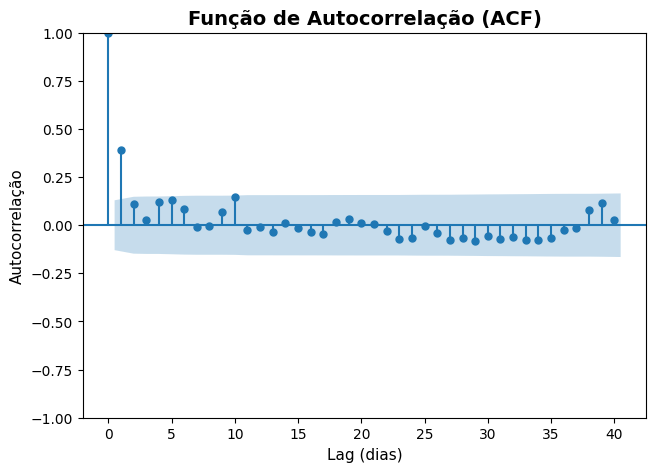

In [ ]:
# ACF - Autocorrelação
plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
plot_acf(eventos_por_dia_df['quantidade'].dropna(), lags=40, ax=plt.gca())
plt.title('Função de Autocorrelação (ACF)', fontsize=14, fontweight='bold')
plt.xlabel('Lag (dias)', fontsize=11)
plt.ylabel('Autocorrelação', fontsize=11)

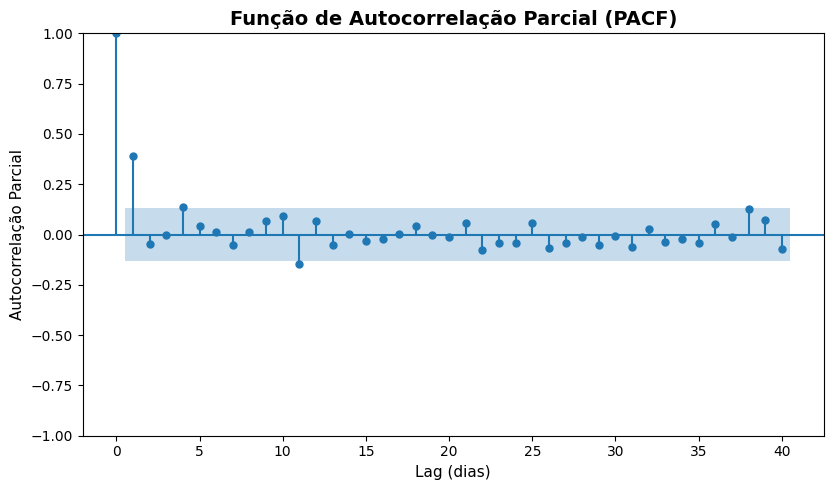

In [ ]:
# PACF - Autocorrelação Parcial
plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 2)
plot_pacf(eventos_por_dia_df['quantidade'].dropna(), lags=40, ax=plt.gca())
plt.title('Função de Autocorrelação Parcial (PACF)', fontsize=14, fontweight='bold')
plt.xlabel('Lag (dias)', fontsize=11)
plt.ylabel('Autocorrelação Parcial', fontsize=11)

plt.tight_layout()
plt.savefig('acf_pacf.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
# Preparar dados para modelagem
serie_temporal = eventos_por_dia_df['quantidade'].values

# Dividir em treino (80%) e teste (20%)
tamanho_treino = int(len(serie_temporal) * 0.8)
treino = serie_temporal[:tamanho_treino]
teste = serie_temporal[tamanho_treino:]

print(f"📊 Dados de treino: {len(treino)} dias")
print(f"📊 Dados de teste: {len(teste)} dias")

# Treinar modelo ARIMA
# Parâmetros escolhidos com base na ACF/PACF
print("\n🔄 Treinando modelo ARIMA(2,1,2)...")

modelo = ARIMA(treino, order=(2, 1, 2))
modelo_treinado = modelo.fit()

print("✅ Modelo treinado com sucesso!")
print("\n📋 Resumo do Modelo:")
print(modelo_treinado.summary())

📊 Dados de treino: 183 dias
📊 Dados de teste: 46 dias

🔄 Treinando modelo ARIMA(2,1,2)...
✅ Modelo treinado com sucesso!

📋 Resumo do Modelo:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  183
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -405.996
Date:                Sun, 30 Nov 2025   AIC                            821.993
Time:                        01:50:24   BIC                            838.013
Sample:                             0   HQIC                           828.487
                                - 183                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5413      0.117     -4.608      0.000      -0.772  

In [ ]:
from sklearn.metrics import mean_squared_error


📊 MÉTRICAS DE AVALIAÇÃO:
   • MSE (Erro Quadrático Médio): 3.45
   • RMSE (Raiz do MSE): 1.86
   • Média dos dados de teste: 2.09
   • Erro relativo: 89.0%


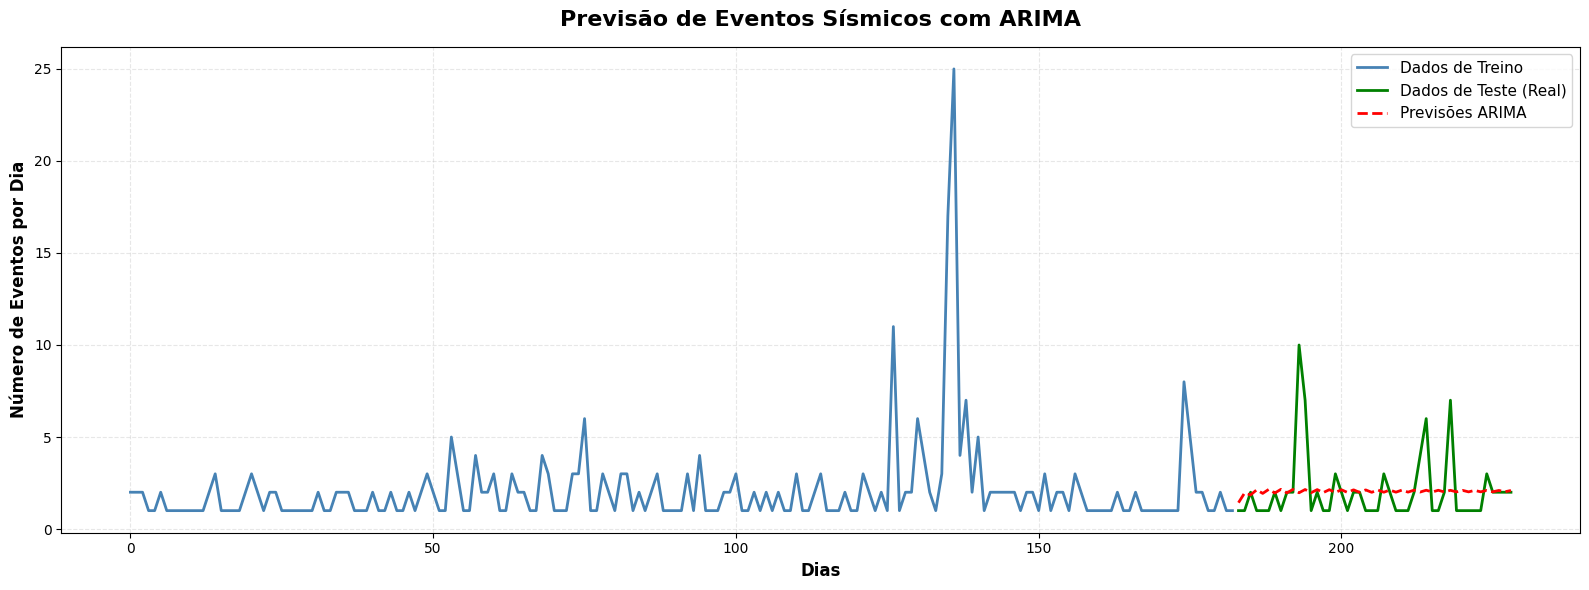

In [ ]:
# Fazer previsões
previsoes = modelo_treinado.forecast(steps=len(teste))

# Calcular erro
mse = mean_squared_error(teste, previsoes)
rmse = np.sqrt(mse)

print(f"\n📊 MÉTRICAS DE AVALIAÇÃO:")
print(f"   • MSE (Erro Quadrático Médio): {mse:.2f}")
print(f"   • RMSE (Raiz do MSE): {rmse:.2f}")
print(f"   • Média dos dados de teste: {teste.mean():.2f}")
print(f"   • Erro relativo: {(rmse/teste.mean())*100:.1f}%")

# Plotar resultados
plt.figure(figsize=(16, 6))

# Dados de treino
plt.plot(range(len(treino)), treino, label='Dados de Treino',
         color='steelblue', linewidth=2)

# Dados de teste (real)
plt.plot(range(len(treino), len(serie_temporal)), teste,
         label='Dados de Teste (Real)', color='green', linewidth=2)

# Previsões
plt.plot(range(len(treino), len(serie_temporal)), previsoes,
         label='Previsões ARIMA', color='red', linewidth=2, linestyle='--')

plt.title('Previsão de Eventos Sísmicos com ARIMA',
          fontsize=16, fontweight='bold', pad=15)
plt.ylabel('Número de Eventos por Dia', fontsize=12, fontweight='bold')
plt.xlabel('Dias', fontsize=12, fontweight='bold')
plt.legend(loc='upper right', fontsize=11)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.savefig('previsao_arima.png', dpi=300, bbox_inches='tight')
plt.show()